In [1]:
import pandas as pd
from langdetect import detect
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df1 = pd.read_csv("../data/api_data_part1.csv")
df2= pd.read_csv("../data/api_data_part2.csv")

df = pd.concat([df1, df2], ignore_index=True)
df.head()


,artist,country,award,gender,album_count
0,10cc,NaN,No awards,Unknown,23
1,110,NaN,No awards,Unknown,0
2,13,NaN,No awards,Unknown,0
3,19,NaN,No awards,Unknown,5
4,3 Doors Down,NaN,No awards,Unknown,10


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18828 entries, 0 to 18827
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   artist       18828 non-null  object
 1   country      10299 non-null  object
 2   award        18828 non-null  object
 3   gender       18828 non-null  object
 4   album_count  18828 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 735.6+ KB


In [4]:
df.shape

(18828, 5)

In [5]:
df.isna().sum()

artist            0
country        8529
award             0
gender            0
album_count       0
dtype: int64

In [6]:
df['country'] = df['country'].fillna('Unknown')

In [7]:
df.isna().sum()

artist         0
country        0
award          0
gender         0
album_count    0
dtype: int64

### Duplicated

In [8]:
df.duplicated().sum()

0

In [9]:
df = df.drop_duplicates()

In [10]:
df.shape

(18828, 5)

In [11]:
df.shape

(18828, 5)

In [15]:
from langdetect import detect
from tqdm import tqdm

# Paso 1: Filtrar premios en inglés
palabras_no_ingles = [
    "stär um", "para", "prêmio", "premio", "prix", "voor", "de", "sus", "la", "das", "del", "der", "des",
    "el", "le", "pe", "stella", "sulla", "nagroda", "carriera", "réalta", "premi", "xelata",
    "tähti", "æresdoktor", "famen", "doktor", "oriel", "anfarwolion", "auf dem", "or merit", "kpakpando", "stäär üüb"
]
award_lang_cache = {}

def is_english_filtered(text):
    text_l = str(text).lower().strip()
    if text not in award_lang_cache:
        try:
            award_lang_cache[text] = detect(text)
        except:
            award_lang_cache[text] = "unknown"
    if award_lang_cache[text] != "en":
        return False
    return not any(palabra in text_l for palabra in palabras_no_ingles)

# Paso 2: Filtrar solo premios válidos
df_valid_awards = df[df['award'].notna()].copy()
tqdm.pandas(desc="Filtrando premios válidos")
df_valid_awards = df_valid_awards[df_valid_awards['award'].progress_apply(is_english_filtered)]

# Paso 3: Agrupar los premios válidos por artista
premios_agrupados = df_valid_awards.groupby("artist")["award"].apply(lambda x: sorted(set(x))).reset_index()
premios_agrupados["award_count"] = premios_agrupados["award"].apply(len)
premios_agrupados["won_grammy"] = premios_agrupados["award"].apply(lambda premios: any("grammy" in str(premio).lower() for premio in premios))
premios_agrupados["awards_list"] = premios_agrupados["award"].apply(lambda x: "; ".join(x))

# Paso 4: Obtener atributos más comunes (país, género, álbumes)
def valor_mas_comun(serie):
    if not serie.mode().empty:
        return serie.mode().iloc[0]
    elif not serie.dropna().empty:
        return serie.dropna().iloc[0]
    else:
        return "Unknown"

atributos_agrupados = df.groupby("artist").agg({
    "country": valor_mas_comun,
    "gender": valor_mas_comun,
    "album_count": valor_mas_comun
}).reset_index()

# Paso 5: Unir los datos de premios con atributos
df_final = atributos_agrupados.merge(premios_agrupados.drop(columns=["award"]), on="artist", how="left")

# Rellenar artistas sin premios
df_final["award_count"] = df_final["award_count"].fillna(0).astype(int)
df_final["won_grammy"] = df_final["won_grammy"].fillna(False)
df_final["awards_list"] = df_final["awards_list"].fillna("No awards")

# Reordenar columnas
df_final = df_final[[
    "artist", "gender", "country", "award_count",
    "won_grammy", "awards_list", "album_count"
]]

# Vista final
df_final.head()


Filtrando premios válidos: 100%|██████████| 18828/18828 [00:08<00:00, 2121.82it/s]


,artist,gender,country,award_count,won_grammy,awards_list,album_count
0,04 Limited Sazabys,Unknown,Unknown,1,False,No awards,10
1,10 Years,Unknown,Unknown,1,False,No awards,9
2,10cc,Unknown,Unknown,1,False,No awards,23
3,10cm,Unknown,Unknown,1,False,No awards,0
4,110,Unknown,Unknown,1,False,No awards,0


In [18]:
df_final.shape

(9326, 7)

### Graphics

Text(0, 0.5, 'Cantidad de artistas')

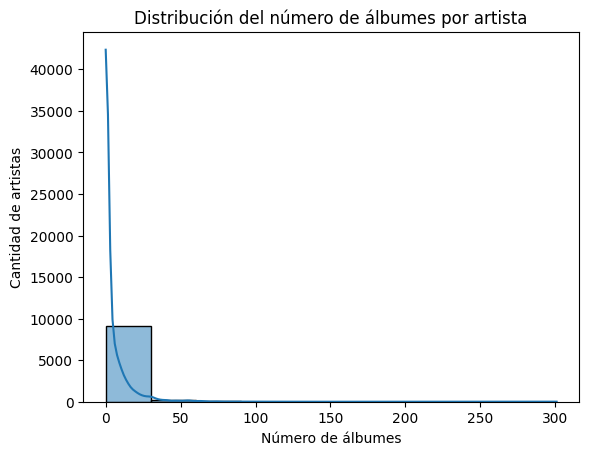

In [19]:
fig1, ax1 = plt.subplots()
sns.histplot(df_final["album_count"], bins=10, kde=True, ax=ax1)
ax1.set_title("Distribución del número de álbumes por artista")
ax1.set_xlabel("Número de álbumes")
ax1.set_ylabel("Cantidad de artistas")

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_final, x="won_grammy", palette="Set2")
plt.title("🏆 Artistas que ganaron al menos un Grammy")
plt.xticks([0, 1], ["No", "Sí"])
plt.xlabel("Ganó Grammy")
plt.ylabel("Cantidad de artistas")
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Número de premios')

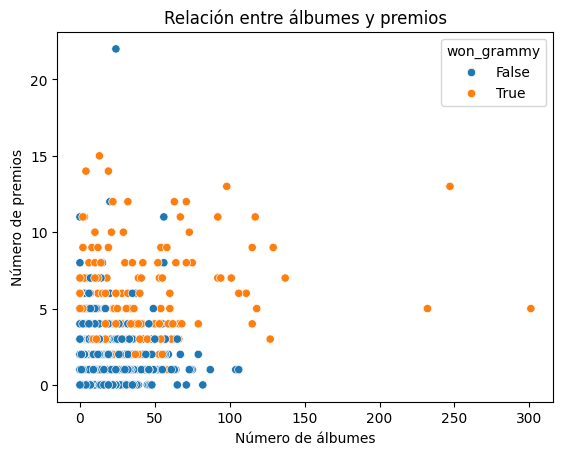

In [23]:
fig3, ax3 = plt.subplots()
sns.scatterplot(data=df_final, x="album_count", y="award_count", hue="won_grammy", ax=ax3)
ax3.set_title("Relación entre álbumes y premios")
ax3.set_xlabel("Número de álbumes")
ax3.set_ylabel("Número de premios")

C:\Users\natym\AppData\Local\Temp\ipykernel_1872\25065897.py:7: UserWarning: Glyph 127758 (\N{EARTH GLOBE AMERICAS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\natym\Desktop\Workshop_002\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127758 (\N{EARTH GLOBE AMERICAS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


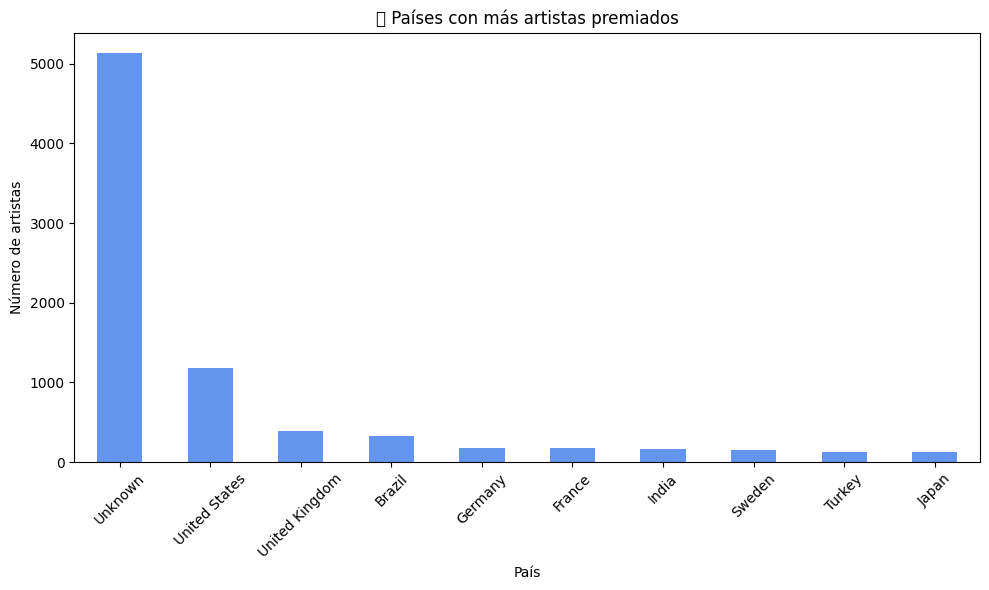

In [24]:
plt.figure(figsize=(10, 6))
df_final["country"].value_counts().head(10).plot(kind="bar", color="cornflowerblue")
plt.title("🌎 Países con más artistas premiados")
plt.ylabel("Número de artistas")
plt.xlabel("País")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\natym\AppData\Local\Temp\ipykernel_1872\2570905075.py:6: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\natym\Desktop\Workshop_002\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


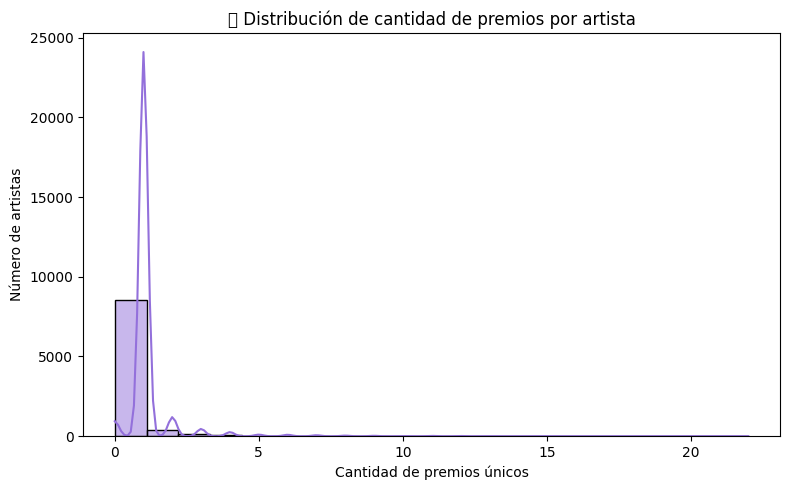

In [25]:
plt.figure(figsize=(8, 5))
sns.histplot(df_final["award_count"], bins=20, kde=True, color="mediumpurple")
plt.title("🎯 Distribución de cantidad de premios por artista")
plt.xlabel("Cantidad de premios únicos")
plt.ylabel("Número de artistas")
plt.tight_layout()
plt.show()

C:\Users\natym\AppData\Local\Temp\ipykernel_1872\3000398801.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=premios_por_pais.values, y=premios_por_pais.index, palette="Blues_d")
C:\Users\natym\AppData\Local\Temp\ipykernel_1872\3000398801.py:8: UserWarning: Glyph 127941 (\N{SPORTS MEDAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\natym\Desktop\Workshop_002\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127941 (\N{SPORTS MEDAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


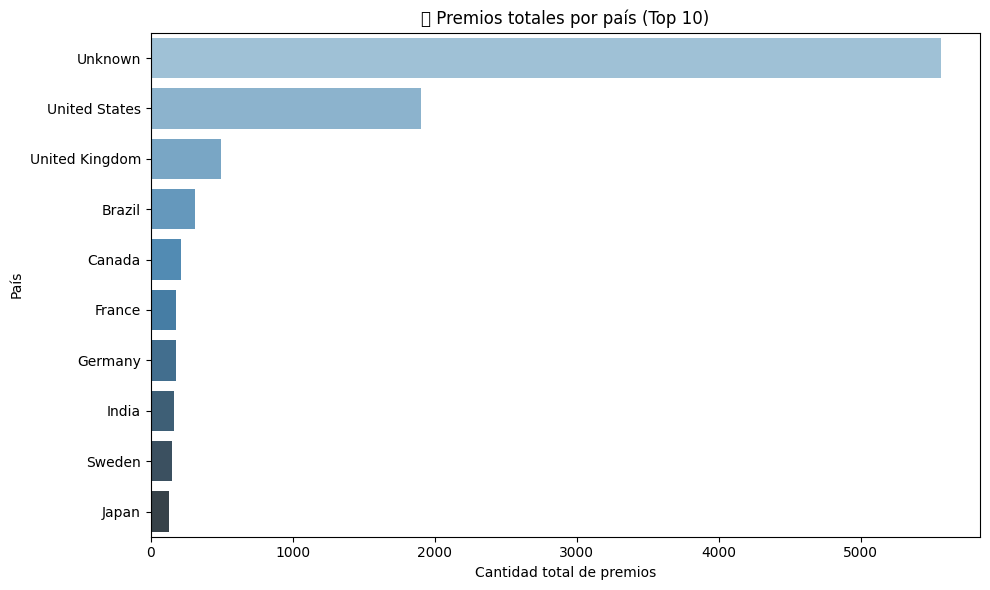

In [26]:
premios_por_pais = df_final.groupby("country")["award_count"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=premios_por_pais.values, y=premios_por_pais.index, palette="Blues_d")
plt.title("🏅 Premios totales por país (Top 10)")
plt.xlabel("Cantidad total de premios")
plt.ylabel("País")
plt.tight_layout()
plt.show()

C:\Users\natym\AppData\Local\Temp\ipykernel_1872\3875207845.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=grammy_por_genero.index, y=grammy_por_genero.values, palette="Set2")
C:\Users\natym\AppData\Local\Temp\ipykernel_1872\3875207845.py:8: UserWarning: Glyph 127908 (\N{MICROPHONE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\natym\Desktop\Workshop_002\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127908 (\N{MICROPHONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


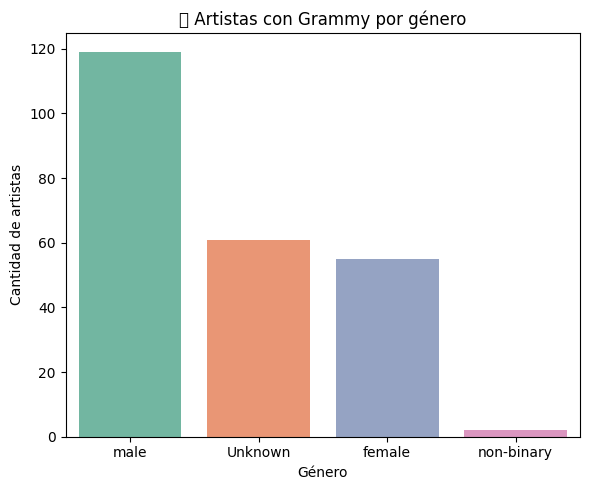

In [27]:
grammy_por_genero = df_final[df_final["won_grammy"] == True]["gender"].value_counts()

plt.figure(figsize=(6, 5))
sns.barplot(x=grammy_por_genero.index, y=grammy_por_genero.values, palette="Set2")
plt.title("🎤 Artistas con Grammy por género")
plt.xlabel("Género")
plt.ylabel("Cantidad de artistas")
plt.tight_layout()
plt.show()